In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

### Functions

In [2]:
def count_matches(seq1, seq2, key_sites=None):

    if key_sites is not None:
        sites = key_sites
    else:
        sites = np.arange(len(seq1))
    
    n_matches = 0
    for i in sites:
        if seq1[i] == seq2[i]:
            n_matches += 1

    return n_matches

In [3]:
def search_tata(seqs, positional=False, key_sites=None):
    if key_sites is not None:
        matches = np.zeros(len(key_sites) + 1)
    else:
        matches = np.zeros(7)

    if positional:
        matches_pos = np.zeros((7, 160))
    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - 6):
            window = seq[i:(i+6)]
            m = count_matches(window, 'TATAAT', key_sites=key_sites)
            matches[m] += 1
            if positional:
                matches_pos[m, i] += 1
    if positional:
        return matches, matches_pos
    else:
        return matches

### Finding TATA-boxes in the entire genome

In [4]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [5]:
matches = search_tata([genome])

In [6]:
print('There are {} TATA-like boxes in the E. coli genome'.format(np.sum(matches[4:])))

There are 163481.0 TATA-like boxes in the E. coli genome


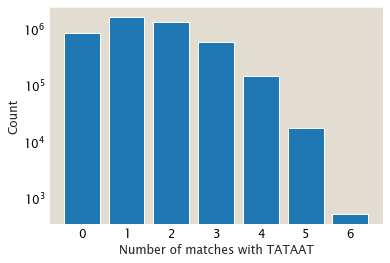

In [7]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,7,1), matches)
ax.set_yscale('log')
ax.set_xlabel('Number of matches with TATAAT')
ax.set_ylabel('Count')
plt.show()

In [8]:
matches = search_tata([genome], key_sites=[2,3,4])

In [9]:
matches

array([2001293., 1922703.,  648792.,   68858.])

In [10]:
print('There are {} TATA-like boxes in the E. coli genome'.format(matches[-1]))

There are 68858.0 TATA-like boxes in the E. coli genome


### Find TATA-boxes in the promoters

In [11]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
df = df.drop_duplicates(subset='tss')
df.head()

,gene,promoter,gene_position,direction,tss,evidence
0,accA,accAp2,208621.0,+,208326.0,"[""none"", ""EXP""]"
1,accA,accAp1,208621.0,+,208411.0,"[""COMP"", ""EXP"", ""EXP""]"
2,accB,accBp1,3405436.0,+,3405140.0,"[""COMP"", ""EXP"", ""COMP""]"
4,accB,accBp2,3405436.0,+,3405172.0,"[""none"", ""EXP""]"
6,accD,accDp,2433926.0,-,2434015.0,"[""COMP"", ""COMP"", ""EXP""]"


In [12]:
promoters = []
for index, row in df.iterrows():
    promoter = tregs.seq_utils.get_regulatory_region(genome, int(row['tss']), reverse=True)
    promoters.append(promoter)

In [13]:
matches_promoters = search_tata(promoters)

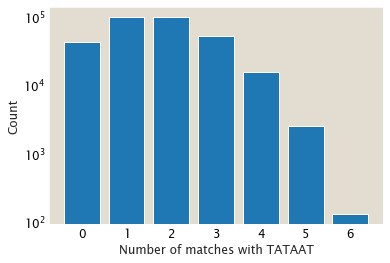

In [14]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,7,1), matches_promoters)
ax.set_yscale('log')
ax.set_xlabel('Number of matches with TATAAT')
ax.set_ylabel('Count')
plt.show()

In [15]:
np.sum(matches_promoters[4:]) / np.sum(matches_promoters) * 100

5.903245173318166

### Plotting the position of the TATAAT boxes

In [16]:
matches, pos = search_tata(promoters, positional=True)

In [17]:
pos

array([[287., 326., 320., ...,   0.,   0.,   0.],
       [706., 686., 698., ...,   0.,   0.,   0.],
       [664., 622., 596., ...,   0.,   0.,   0.],
       ...,
       [ 82.,  86.,  84., ...,   0.,   0.,   0.],
       [  9.,   8.,  10., ...,   0.,   0.,   0.],
       [  1.,   0.,   1., ...,   0.,   0.,   0.]])

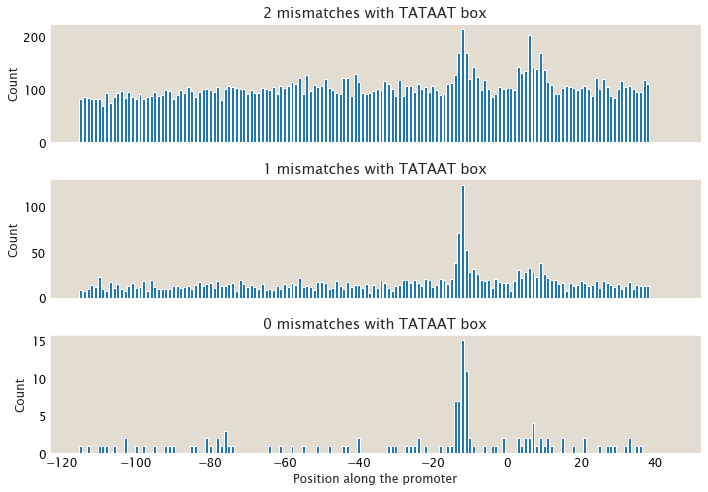

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10,7),
                         sharex=True)
for i in range(3):
    axes[i].bar(np.arange(-115, 45), pos[4:][i, :])
    axes[i].set_title('{} mismatches with TATAAT box'.format(2-i))
    axes[i].set_ylabel('Count', fontsize=12)

axes[-1].set_xlabel('Position along the promoter', fontsize=12)

plt.tight_layout()
plt.show()

### Counting the number of mismatches after enforcing the TAXXXT motif

In [19]:
def count_strong_matches(seq1, seq2, key_sites):

    matched = True
    for i in key_sites:
        if seq1[i] != seq2[i]:
            matched = False
    
    if matched:    
        n_matches = 0
        for ii in range(len(seq1)):
            if ii not in key_sites:
                if seq1[ii] == seq2[ii]:
                    n_matches += 1
    else:
        n_matches = -1

    return n_matches

In [20]:
def search_tata_strong(seqs, key_sites):

    matches = np.zeros(len(key_sites) + 1)
    matches_pos = np.zeros((len(key_sites) + 1, 160))

    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - 6):
            window = seq[i:(i+6)]
            m = count_strong_matches(window, 'TATAAT', key_sites)
            matches[m] += 1
            matches_pos[m, i] += 1

    return matches, matches_pos

In [21]:
matches, pos2 = search_tata_strong(promoters, [0, 1, 5])

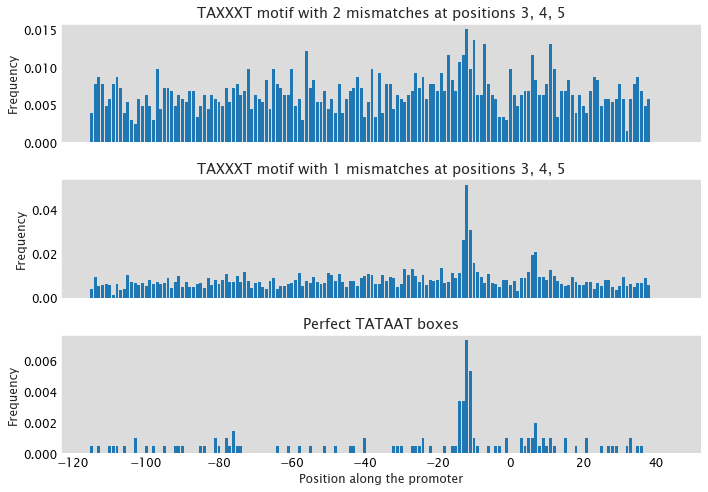

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(10,7),
                         sharex=True)

for i in range(3):
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_facecolor("gainsboro")


for i in range(2):
    axes[i].bar(np.arange(-115, 45), pos2[:2][i, :] / len(promoters), linewidth=0)
    axes[i].set_title('TAXXXT motif with {} mismatches at positions 3, 4, 5'.format(2-i))


axes[-1].bar(np.arange(-115, 45), pos[4:][2, :] / len(promoters), linewidth=0)
axes[-1].set_xlabel('Position along the promoter', fontsize=12)
axes[-1].set_title('Perfect TATAAT boxes')

plt.tight_layout()
plt.savefig('../../figs/tata_boxes.png', dpi=300, bbox_inches='tight')
plt.show()